# Model training dataset creation

This notebook implements training dataset creation tools for implementing a NN based receiver, which plugs in the DFT output and returns the bits (probabilities), and hence replaces the channel estimation, equalization and demapper functionalities entirely. (refer to https://arxiv.org/abs/2005.01494 for more) 

In [1]:
from config import *
from OFDM_SDR_Functions_torch import *
import torch
from torch.utils.data import Dataset
import numpy as np
import random

Create the modulation mapping and demapping tables, the TTI mask and place the pilot symbols in the mask.

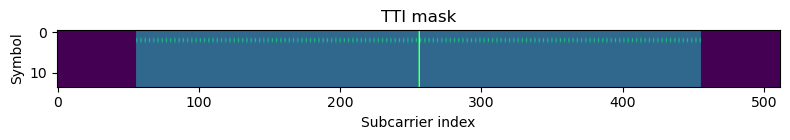

In [2]:
mapping_table_QPSK, de_mapping_table_QPSK = mapping_table(2) # mapping table QPSK (e.g. for pilot symbols)
mapping_table_Qm, de_mapping_table_Qm = mapping_table(Qm, plot=False) # mapping table for Qm

TTI_mask_RE = TTI_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset, plotTTI=True) # TTI mask
pilot_symbols = pilot_set(TTI_mask_RE, Pilot_Power) # pilot symbols

Create the bitstream and modulate it. Place the modulated symbols in the TTI, do the FFT and add cyclic prefix.

In [3]:
def create_OFDM_data():
    pdsch_bits, pdsch_symbols = create_PDSCH_data(TTI_mask_RE, Qm, mapping_table_Qm, power=PDSCH_power) # PDSCH data bits stream, modulated symbols
    Modulated_TTI = RE_mapping(TTI_mask_RE, pilot_symbols, pdsch_symbols, plotTTI=False) # TTI with pilot and PDSCH symbols
    TD_TTI_IQ = FFT(Modulated_TTI) # TTI in time domain
    TX_Samples = CP_addition(TD_TTI_IQ, S, FFT_size, CP) # TTI with cyclic prefix
    return pdsch_bits, TX_Samples 

Make a custom torch dataset. The structure of the dataset is defined in the config file.

In [4]:
dataset = CustomDataset()

Create a loop to make data for the dataset, and finally save it. To speed the process up, instead of using the SDR for radio channels creation, the implemented simple CDL-C radio channel model is used instead. The dataset is not shared in this repository due to it being easily very large. You can easily create your own.

In [5]:
number_of_training_items = 1000

ch_SINR_min = 15 # channel emulation min SINR
ch_SINR_max = 35 # channel emulation max SINR

for i in range(number_of_training_items):
    if i % 100 == 0:
        print(i)
    ch_SINR = int(random.uniform(ch_SINR_min, ch_SINR_max)) # SINR generation
    pdsch_bits, TX_Samples = create_OFDM_data() # data stream
    RX_Samples = generate_cdl_c_impulse_response(tx_signal = TX_Samples, num_samples=100, sampling_rate=SampleRate, SINR=ch_SINR, repeats = 2, random_start=False) # convolve channel with tx signal
    RX_NO_CP = CP_removal(RX_Samples, 0, S, FFT_size, CP, plotsig=False) # remove cyclic prefix
    RX_NO_CP = RX_NO_CP / torch.max(torch.abs(RX_NO_CP)) # normalize
    OFDM_demod = DFT(RX_NO_CP, plotDFT=False) # DFT
    pilot_symbols = get_pilot_symbols_raw(TTI_mask_RE, OFDM_demod) # get pilot symbols
    pdsch_symbols = get_payload_symbols_raw(TTI_mask_RE, OFDM_demod) # get PDSCH symbols
    dataset.add_item(pdsch_symbols, pilot_symbols, pdsch_bits) # add to dataset
    
torch.save(dataset, 'data/ofdm_dataset.pth') # save dataset on disk
    

0
100
200
300
400
500
600
700
800
900


In [6]:
# print the last item in the dataset
print(f'Shape of the received symbols tensor: {dataset.pdsch_iq[-1].shape}, pilots tensor {dataset.pilot_iq[-1].shape}, and original modulated bits tensor {dataset.labels[-1].shape}') 

Shape of the received symbols tensor: torch.Size([5452]), pilots tensor torch.Size([134]), and original modulated bits tensor torch.Size([5452, 6])
